In [1]:
import os
import pandas as pd
import quantstats as qs
from sklearn.externals.array_api_compat.torch import newaxis

from src.models.AttentionLSTM import AttentionLSTM

In [2]:
RAW_DIR = f"../../data/raw/interval-1d"
PROC_DIR = f"../../data/processed/interval-1d"
os.makedirs(PROC_DIR, exist_ok=True)


In [3]:
df = pd.read_csv(os.path.join(PROC_DIR, "AAPL.csv"))
df2 = pd.read_csv(os.path.join(PROC_DIR, "AMZN.csv"))
stock_dfs = {
    fname.replace(".csv", ""): pd.read_csv(os.path.join(PROC_DIR, fname))
    for fname in os.listdir(PROC_DIR)
    if fname.endswith(".csv")
}
stock_dfs["F"]

,Date,Adj Close,Close,High,Low,Open,Volume,Return,Target,Moving averages,...,Open change,Open original,High change,High original,Low change,Low original,Close change,Close original,Adj Close change,Adj Close original
0,2018-01-09,-0.320246,-0.143532,-0.179487,-0.106320,-0.134951,17.145001,-0.007587,-0.002297,0.004110,...,-0.002271,13.18,0.000000,13.22,-0.002288,13.08,-0.005323,13.08,-0.005323,8.635981
1,2018-01-10,-0.324283,-0.148253,-0.186946,-0.118079,-0.146602,17.850054,-0.002297,0.010753,0.002389,...,-0.009105,13.06,-0.006051,13.14,-0.009174,12.96,-0.003823,13.03,-0.003822,8.602971
2,2018-01-11,-0.313786,-0.135977,-0.181352,-0.114160,-0.150485,17.159866,0.010753,0.009924,0.001409,...,-0.003063,13.02,0.004566,13.20,0.003086,13.00,0.009977,13.16,0.009977,8.688802
3,2018-01-12,-0.308134,-0.129367,-0.172960,-0.104361,-0.142718,17.858197,0.009924,-0.015778,0.001250,...,0.006144,13.10,0.006818,13.29,0.007692,13.10,0.005319,13.23,0.005319,8.735017
4,2018-01-16,-0.318631,-0.141643,-0.155245,-0.113180,-0.122330,17.803780,-0.015778,-0.031796,-0.000997,...,0.016031,13.31,0.014296,13.48,-0.006870,13.01,-0.009826,13.10,-0.009826,8.649186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910,2025-08-15,0.022679,-0.298395,-0.337995,-0.269966,-0.304854,17.647221,0.000875,0.005263,0.003731,...,0.011504,11.43,0.006114,11.52,0.016934,11.41,0.000000,11.44,0.000000,11.440000
1911,2025-08-18,0.025125,-0.296506,-0.341725,-0.273885,-0.307767,17.429499,0.005263,0.005208,0.007615,...,-0.002625,11.40,-0.003472,11.48,-0.003506,11.37,0.001748,11.46,0.001748,11.460000
1912,2025-08-19,0.039800,-0.285175,-0.318415,-0.262126,-0.296116,17.876302,0.005208,-0.002604,0.007764,...,0.010526,11.52,0.021777,11.73,0.010554,11.49,0.010471,11.58,0.010471,11.580000
1913,2025-08-20,0.028794,-0.293673,-0.330536,-0.264086,-0.296116,17.654315,-0.002604,-0.007881,0.004226,...,0.000000,11.52,-0.011083,11.60,-0.001741,11.47,-0.007772,11.49,-0.007772,11.490000


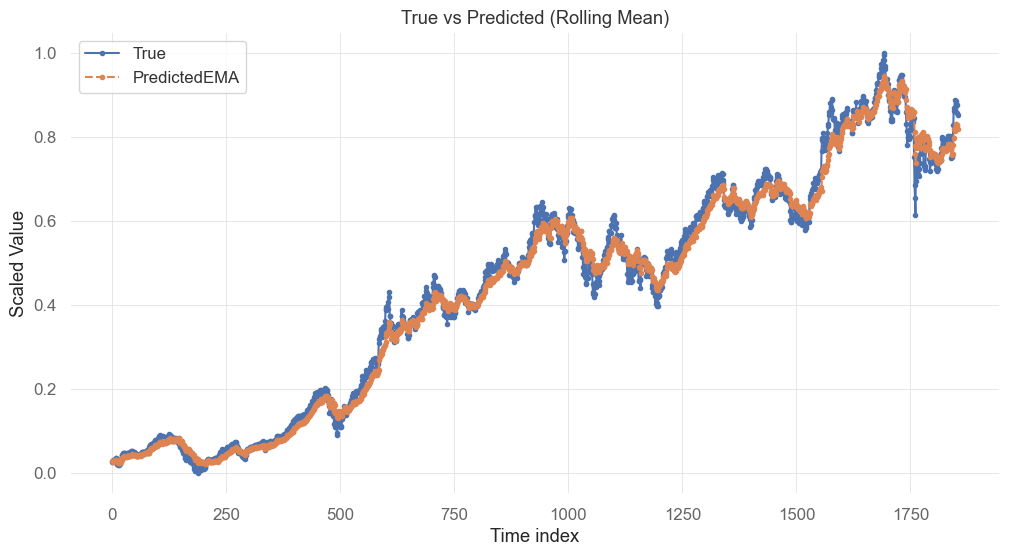

MSE error is 0.002323
MAE error is 0.000678


In [4]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assume df already exists
data = df[['Adj Close']].copy()

# Scale entire column (not in chunks of 30 — that breaks continuity)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Convert back to DataFrame for easier indexing
data_scaled = pd.DataFrame(data_scaled, columns=['Adj Close'])

# Sliding windows
win_size = 60
windows = np.lib.stride_tricks.sliding_window_view(
    data_scaled['Adj Close'].values, win_size
)

# Predictions: rolling mean of last 30 values
pred = []
predEMA = []
true = []
error = 0
errorEMA = 0
running_mean = 0
gamma = 0.5
for i in range(win_size, int(len(data_scaled))):
    pred_val = np.mean(windows[i - win_size])
    running_mean = data_scaled['Adj Close'].iloc[i - 1] * gamma + pred_val * (1 - gamma)
    true_val = data_scaled['Adj Close'].iloc[i]

    pred.append(pred_val)
    predEMA.append(running_mean)
    true.append(true_val)

    error += (true_val - pred_val) ** 2
    errorEMA += (running_mean - true_val) ** 2

# Plot
plt.figure(figsize=(12,6))
plt.plot(true, label="True", marker="o", markersize=3, linestyle="-")
# plt.plot(pred, label="Predicted", marker="x", markersize=3, linestyle="--")
plt.plot(predEMA, label="PredictedEMA", marker="o", markersize=3, linestyle="--")
plt.xlabel("Time index")
plt.ylabel("Scaled Value")
plt.title("True vs Predicted (Rolling Mean)")
plt.legend()
plt.show()

print(f"MSE error is {error/len(true):.6f}")

print(f"MAE error is {errorEMA/len(true):.6f}")

In [5]:
import torch.nn as nn
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term[:len(pe[0,1::2])])
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        return x + self.pe[:, :x.size(1)]

In [9]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from src.models.AttentionLSTM import AttentionLSTM
import matplotlib.pyplot as plt
class TestTransformer(torch.nn.Module):
    def __init__(self, n_features, d_model=64, n_heads=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(n_features, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, 1)  # predict next value

    def forward(self, x):
        """
        x: (batch, seq_len, n_features)
        returns: (batch, 1)
        """
        x = self.input_proj(x)       # project to d_model
        x = self.pos_enc(x)          # add positional encoding
        enc_out = self.encoder(x)    # (batch, seq_len, d_model)
        pooled = enc_out[:, -1, :]   # use last timestep for prediction
        out = self.output_proj(pooled)
        return out

class TestRNN(torch.nn.Module):
    def __init__(self, d_model, hidden_size, num_layers = 3, dropout = 0.05):
        super(TestRNN, self).__init__()
        self.d_model = d_model
        self.PE = PositionalEncoding(self.d_model, 60)
        self.t=nn.LSTM(input_size=self.d_model, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.final = nn.Linear(in_features=hidden_size, out_features=1)
    def forward(self, x, return_hidden=False):
        x = self.PE(x)
        out, (h_n, c_n) = self.t(x)  # out: (batch, seq_len, hidden_size)
        last_hidden = out[:, -1, :]  # (batch, hidden_size)

        if return_hidden:
            return c_n[-1, :, :]      # for Predictor / attention
        else:
            return self.final(last_hidden)  # for old code that predicts directly

class Predictor(nn.Module):
    def __init__(self, target_dim, other_dim, hidden_dim, rnn_hidden=64, num_layers=3, dropout=0.05):
        super(Predictor, self).__init__()
        # RNN branch for target stock
        self.rnn = TestRNN(target_dim, rnn_hidden, num_layers, dropout)

        # Attention layers
        self.query = nn.Linear(rnn_hidden, hidden_dim)
        self.key   = nn.Linear(other_dim, hidden_dim)
        self.value = nn.Linear(other_dim, hidden_dim)

        # Final prediction head
        self.final = nn.Linear(rnn_hidden + hidden_dim, 1)

    def forward(self, target_x, other_x):
        """
        target_x: (batch, seq_len, target_dim)    -> history of target stock
        other_x:  (batch, n_stocks, other_dim)    -> features of other stocks at prediction time
        """
        # Encode target stock sequence
        rnn_out = self.rnn(target_x, return_hidden = True)  # (batch, rnn_hidden)

        # Project into attention space
        Q = self.query(rnn_out).unsqueeze(1)  # (batch, 1, hidden_dim)
        K = self.key(other_x)                 # (batch, n_stocks, hidden_dim)
        V = self.value(other_x)               # (batch, n_stocks, hidden_dim)

        # Scaled dot-product attention
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (K.size(-1) ** 0.5)  # (batch, 1, n_stocks)
        attn_weights = F.softmax(attn_scores, dim=-1)                             # (batch, 1, n_stocks)
        context = torch.matmul(attn_weights, V).squeeze(1)                        # (batch, hidden_dim)

        # Concatenate RNN output + attention context
        combined = torch.cat([rnn_out, context], dim=-1)  # (batch, rnn_hidden + hidden_dim)

        # Final prediction
        out = self.final(combined)  # (batch, 1)
        return out, attn_weights.squeeze(1)   # also return weights to inspect relevance



scaler = MinMaxScaler()
# Separate numeric stock features
cutoff_date = "2025-08-20"

numeric_features = [ 'Adj Close original']
cyclical_features = ['Volume']
                # + [cyclical_features[0]])
extra_features = ['EMA_5', 'EMA_26', 'EMA_diff_5_26', 'Trend_strength']
all_features = (numeric_features + cyclical_features + extra_features)
target_features = numeric_features + cyclical_features
all_numeric = numeric_features + extra_features

scaled_stock_dfs = {}
stock_scalers = {}

for ticker, df in stock_dfs.items():
    df = df.copy()
    # print(ticker)
    # print(df)
    df['Date'] = pd.to_datetime(df['Date'])

    # create scaler per stock
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(df.loc[df['Date'] < cutoff_date][all_numeric])

    # store scaler for later inverse_transform
    stock_scalers[ticker] = scaler

    # scale numeric + extra features
    df[all_numeric] = scaler.transform(df[all_numeric])

    # keep cyclical features untouched
    scaled_stock_dfs[ticker] = df[all_features]


returns = scaled_stock_dfs


window_size=60

X = []
Y = []
Z = []
X2 = []
Y2 = []
for ticker, df_ticker in scaled_stock_dfs.items():
    if ticker != "AMZN":
        for i in range(0, int(len(df_ticker)*5/5-window_size)):
            Z.append(df_ticker.iloc[i:i+window_size][extra_features].values)
    else:
        for i in range(0, int(len(df_ticker)*5/5-window_size)):
            X.append(df_ticker.iloc[i:i+window_size][target_features].values)
            Y.append(df_ticker.iloc[i+window_size]['Adj Close original'])

X = torch.tensor(X, dtype = torch.float32)
Y = torch.tensor(Y, dtype = torch.float32).unsqueeze(-1).unsqueeze(-1)
Z = torch.tensor(Z, dtype = torch.float32)

print(Z.shape)
n_features = X.shape[2]
transformer = TestTransformer(n_features)
rnn = TestRNN(n_features, 64)

predictor = AttentionLSTM(target_dim=n_features ,hidden_dim=64, other_dim=Z.shape[-1])
optimizer_predictor = torch.optim.Adam(predictor.parameters(), lr=1e-2)
criterion_predictor = torch.nn.L1Loss()

optimizer = torch.optim.Adam(transformer.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss()
optimizerRNN = torch.optim.Adam(rnn.parameters(), lr=1e-2)
criterionRNN = torch.nn.L1Loss()
transformer.train()
rnn.train()
batch_size = 100  # you can adjust this
n_samples = X.shape[0]

batch_size = 100
epoch_train = batch_size * 15
n_samples = X.shape[0]
print(n_samples)
for epoch in range(100):
    perm = torch.randperm(n_samples)  # shuffle each epoch
    epoch_loss_rnn = 0.0
    epoch_loss_tf = 0.0
    epoch_loss_predictor = 0.0

    for i in range(0, n_samples, batch_size):
        idx = perm[i:i+batch_size]
        x_batch = X[idx]   # shape: (batch, seq_len, n_features)
        y_batch = Y[idx].reshape(-1, 1)  # (batch, 1)
        z_batch = Z[idx]

        optimizer.zero_grad()
        optimizerRNN.zero_grad()
        optimizer_predictor.zero_grad()

        # Transformer needs a target sequence
        tgt_batch = x_batch[:, -1:, :]  # last value of input window
        # print(y_batch)
        # print(tgt_batch)
        # print()
        outputs_tf = transformer(x_batch)
        outputs_rnn = rnn(x_batch)
        outputs_predictor, _ = predictor(x_batch, z_batch)
        # Compute losses
        loss_rnn = criterionRNN(outputs_rnn, y_batch)
        loss_tf = criterion(outputs_tf, y_batch)
        loss_predictor = criterion_predictor(outputs_predictor, y_batch)
        # print(loss_rnn.item())
        # Backprop
        loss_rnn.backward()
        optimizerRNN.step()

        loss_tf.backward()
        optimizer.step()

        loss_predictor.backward()
        optimizer_predictor.step()

        epoch_loss_rnn += loss_rnn.item() * len(idx)
        epoch_loss_tf += loss_tf.item() * len(idx)
        epoch_loss_predictor += loss_predictor.item() * len(idx)



    avg_loss_rnn = epoch_loss_rnn / n_samples
    avg_loss_tf = epoch_loss_tf / n_samples
    avg_loss_predictor = epoch_loss_predictor / n_samples
    print(f"Epoch {epoch:02d} | RNN Loss: {avg_loss_rnn:.5f} | TF Loss: {avg_loss_tf:.5f} | Predictor Loss: {avg_loss_predictor:.5f}")



torch.Size([96460, 60, 4])
1855
Epoch 00 | RNN Loss: 0.41149 | TF Loss: 1.24367 | Predictor Loss: 0.36943
Epoch 01 | RNN Loss: 0.22533 | TF Loss: 0.23419 | Predictor Loss: 0.31898
Epoch 02 | RNN Loss: 0.11393 | TF Loss: 0.23309 | Predictor Loss: 0.14178
Epoch 03 | RNN Loss: 0.09377 | TF Loss: 0.23234 | Predictor Loss: 0.08960
Epoch 04 | RNN Loss: 0.05834 | TF Loss: 0.23117 | Predictor Loss: 0.05255
Epoch 05 | RNN Loss: 0.05409 | TF Loss: 0.23182 | Predictor Loss: 0.05450
Epoch 06 | RNN Loss: 0.04939 | TF Loss: 0.23279 | Predictor Loss: 0.05515
Epoch 07 | RNN Loss: 0.04625 | TF Loss: 0.23493 | Predictor Loss: 0.04486
Epoch 08 | RNN Loss: 0.05044 | TF Loss: 0.23224 | Predictor Loss: 0.07751
Epoch 09 | RNN Loss: 0.05806 | TF Loss: 0.23138 | Predictor Loss: 0.05217
Epoch 10 | RNN Loss: 0.04804 | TF Loss: 0.23203 | Predictor Loss: 0.04220
Epoch 11 | RNN Loss: 0.04403 | TF Loss: 0.23042 | Predictor Loss: 0.04179
Epoch 12 | RNN Loss: 0.04663 | TF Loss: 0.23104 | Predictor Loss: 0.04608
Epoch 

torch.Size([60, 2])
torch.Size([60, 60, 2])
torch.Size([1, 60, 2])
torch.Size([1, 1, 2])
torch.Size([1, 1])
a fost out
228.13236611819764
232.42848450613633
223.8099979245327

Asta e avg error 0.0004320929208239174
Asta e avg error la RNN 1.251392906327526e-06
Asta a fost mean


/Users/dobrint/TradingApp/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:129: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/Users/dobrint/TradingApp/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


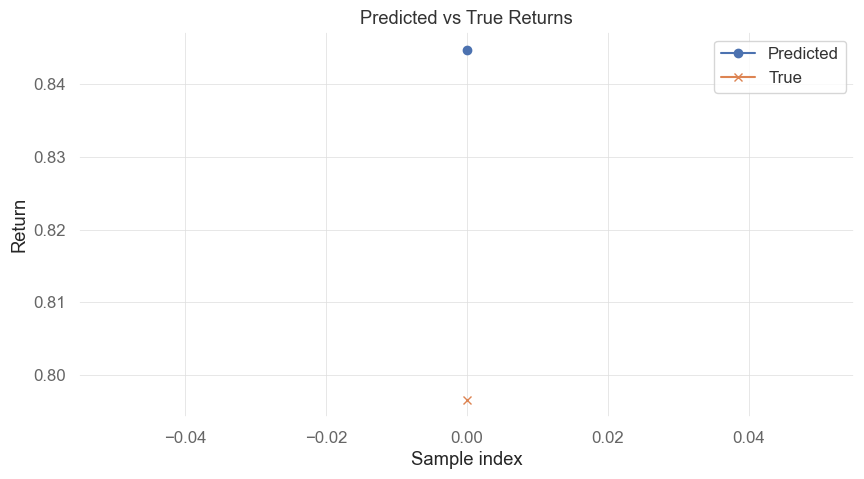

In [8]:
X2 = []
Y2 = []
# for i in range(0, int(len(returns2)*5/5-window_size)):
#     X2.append(returns2.iloc[i:i+window_size].values)
#     Y2.append(returns2.iloc[i+window_size]['Adj Close'])
predictor.eval()
X2 = torch.tensor(X2, dtype = torch.float32)
Y2 = torch.tensor(Y2, dtype = torch.float32).unsqueeze(-1).unsqueeze(-1)
a=X[range(1,61)]
print(a[:,-1,:].shape)
print(a.shape)
transformer.eval()
rnn.eval()
outputsRNN = []
outputs = []
outputsPredictor = []
sumaPred = 0
true = []
suma = 0
sumaRNN = 0
for ticker, df in stock_dfs.items():
    if ticker != "AMZN":
        continue
    df = df.copy()
    # print(ticker)
    # print(df)
    scaler = stock_scalers[ticker]
    df['Date'] = pd.to_datetime(df['Date'])
    y = scaler.transform(df.loc[df['Date'] == cutoff_date][all_numeric])[0][0]
    y = torch.tensor([y], dtype = torch.float32)
    df = df.loc[df['Date'] < cutoff_date]
    # create scaler per stock
    df[all_numeric] = scaler.transform(df[all_numeric])

    x = torch.tensor(df[target_features].values[-window_size:], dtype = torch.float32).unsqueeze(0)
    z = torch.tensor(df[extra_features].values[-window_size:], dtype = torch.float32)

    # tgt = torch.tensor(x[-1].reshape((1,1,6)), dtype=torch.float32)
    tgt = x[:, -1, :].unsqueeze(1)
    print(x.shape)
    print(tgt.shape)
    out = transformer(x)
    outPredictor,_ = predictor(x, z)
    print(out.shape)
    print("a fost out")
    outRNN = rnn(x)
    outputsRNN.append(outRNN.item())
    outputsPredictor.append(outPredictor.item())
    lossPredictor = criterion_predictor(outPredictor, y)
    lossRNN = criterionRNN(outRNN, y.reshape((y.shape[0], 1)))
    loss = criterion(out, y)
    suma+=loss.item()**2
    sumaRNN+=lossRNN.item()**2
    outputs.append(out.item())
    true.append(y.item())
    dummy = np.zeros((1, 5))                 # (1, 3) array
    dummy[0,0] = outRNN.item()               # put prediction in first column
    print(scaler.inverse_transform(dummy)[0,0])

    dummy[0,0] = outPredictor.item()               # put prediction in first column
    print(scaler.inverse_transform(dummy)[0,0])

    dummy[0,0] = y.item()                    # true value
    print(scaler.inverse_transform(dummy)[0,0])


    print()

# for i in range(int(len(X2)*0/5), int(len(X2)*5/5)):
#
#     y = Y2[i]
#     x = X2[i].unsqueeze(0)  # shape: (1, window_size, n_features)
#     # £tgt = torch.zeros(1, 1, x.shape[2])
#     # tgt = torch.zeros(y.shape[0],1,x.shape[2])
#     tgt = x[:, -1:, :]
#     out = transformer(x, tgt)
#     outRNN = rnn(x)
#     outputsRNN.append(outRNN.item())
#     lossRNN = criterionRNN(outRNN, y.reshape((y.shape[0], 1)))
#     loss = criterion(out, y)
#     suma+=loss.item()**2
#     sumaRNN+=lossRNN.item()**2
#     outputs.append(out.item())
#     true.append(y.item())

print(f"Asta e avg error {suma / len(X)}")
print(f"Asta e avg error la RNN {sumaRNN / len(X)}")
print("Asta a fost mean")
plt.figure(figsize=(10,5))
plt.plot(outputsRNN, label='Predicted', marker='o')
plt.plot(true, label='True', marker='x')
plt.xlabel('Sample index')
plt.ylabel('Return')
plt.title('Predicted vs True Returns')
plt.legend()
plt.show()

In [ ]:
class ResidualMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers=2, dropout=0.05):
        super().__init__()
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        for i in range(n_layers):
            in_dim = input_dim if i == 0 else hidden_dim
            self.layers.append(nn.Linear(in_dim, hidden_dim))
            self.norms.append(nn.LayerNorm(hidden_dim))
        self.dropout = nn.Dropout(dropout)
        self.final = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out = x
        for layer, norm in zip(self.layers, self.norms):
            residual = out
            out = F.relu(layer(out))
            out = self.dropout(out)
            out = norm(out + residual)  # Residual connection
        return self.final(out)
class Predictor(nn.Module):
    def __init__(self, target_dim, other_dim, hidden_dim, rnn_hidden=64, num_layers=3, dropout=0.05):
        super(Predictor, self).__init__()
        # RNN branch for target stock
        self.rnn = TestRNN(target_dim, rnn_hidden, num_layers, dropout)

        # Attention layers
        self.query = nn.Linear(rnn_hidden, hidden_dim)
        self.key   = nn.Linear(other_dim, hidden_dim)
        self.value = nn.Linear(other_dim, hidden_dim)

        # Final prediction head
        self.mlp = ResidualMLP(rnn_hidden + hidden_dim, hidden_dim, n_layers=2, dropout=dropout)

    def forward(self, target_x, other_x):
        """
        target_x: (batch, seq_len, target_dim)    -> history of target stock
        other_x:  (batch, n_stocks, other_dim)    -> features of other stocks at prediction time
        """
        # Encode target stock sequence
        rnn_out = self.rnn(target_x, return_hidden = True)  # (batch, rnn_hidden)

        # Project into attention space
        Q = self.query(rnn_out).unsqueeze(1)  # (batch, 1, hidden_dim)
        K = self.key(other_x)                 # (batch, n_stocks, hidden_dim)
        V = self.value(other_x)               # (batch, n_stocks, hidden_dim)

        # Scaled dot-product attention
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (K.size(-1) ** 0.5)  # (batch, 1, n_stocks)
        attn_weights = F.softmax(attn_scores, dim=-1)                             # (batch, 1, n_stocks)
        context = torch.matmul(attn_weights, V).squeeze(1)                        # (batch, hidden_dim)

        # Concatenate RNN output + attention context
        combined = torch.cat([rnn_out, context], dim=-1)  # (batch, rnn_hidden + hidden_dim)

        # Final prediction
        out = self.mlp(combined)  # (batch, 1)
        return out, attn_weights.squeeze(1)   # also return weights to inspect relevance



In [134]:
import numpy as np
import torch
from transformers import TimeSeriesTransformerModel
# Load pretrained model
model = TimeSeriesTransformerModel.from_pretrained(
    "huggingface/time-series-transformer-tourism-monthly"
)
series = df['Close'].iloc[1:].values  # shape: (timesteps,)
timestamps = pd.to_datetime(df['Date'].iloc[1:])

context_length = max(model.config.lags_sequence) + 47
prediction_length = 1

# Create overlapping sequences
past_sequences = []
future_sequences = []
past_time_features_list = []
future_time_features_list = []

for i in range(len(series) - context_length - prediction_length + 1):
    past_sequences.append(series[i:i+context_length])
    future_sequences.append(series[i+context_length:i+context_length+prediction_length])

    # Example time features: month normalized to [0,1]
    # Example time features: month normalized to [0,1]
    past_months = timestamps[i:i+context_length].dt.month.values / 12.0
    past_time_features_list.append(past_months.reshape(-1, 1))  # shape (context_length, 1)

    future_months = timestamps[i+context_length:i+context_length+prediction_length].dt.month.values / 12.0
    future_time_features_list.append(future_months.reshape(-1, 1))  # shape (prediction_length, 1)

past_values = torch.tensor(np.array(past_sequences), dtype=torch.float32)
future_values = torch.tensor(np.array(future_sequences), dtype=torch.float32)
past_time_features = torch.tensor(np.array(past_time_features_list), dtype=torch.float32)
past_observed_mask = torch.ones_like(past_values)  # all ones if no missing data
future_time_features = torch.tensor(np.array(future_time_features_list), dtype=torch.float32)
max_lag = max(model.config.lags_sequence)

print("past_values:", past_values.shape)
print("future_values:", future_values.shape)
print("past_time_features:", past_time_features.shape)
print("future_time_features:", future_time_features.shape)
print("past_observed_mask:", past_observed_mask.shape)



optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()  # regression

# model.train()
# for epoch in range(5):
#     optimizer.zero_grad()
#
#     outputs = model(
#         past_values=past_values,
#         past_time_features=past_time_features,
#         past_observed_mask=None,
#         future_values=future_values,
#         future_time_features=future_time_features,  # optional
#         static_categorical_features=None,
#         static_real_features=None
#     )
#
#     # Predict using the first hidden dim (simplest approach)
#     predictions = outputs.last_hidden_state[:, -prediction_length:, 0]
#     loss = loss_fn(predictions, future_values)
#
#     loss.backward()
#     optimizer.step()
#
#     print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Extract embeddings
# model.eval()
with torch.no_grad():
    embeddings = model.encoder(torch.tensor(np.array(past_values[:,:,np.newaxis]), dtype=torch.float32)
         ).last_hidden_state # shape: [num_sequences, context_length, hidden_size]

print(embeddings.shape)


past_values: torch.Size([1836, 84])
future_values: torch.Size([1836, 1])
past_time_features: torch.Size([1836, 84, 1])
future_time_features: torch.Size([1836, 1, 1])
past_observed_mask: torch.Size([1836, 84])


/var/folders/5y/0nklg1px35745765bb2x1zz00000gq/T/ipykernel_65185/1282593159.py:76: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  embeddings = model.encoder(torch.tensor(np.array(past_values[:,:,np.newaxis]), dtype=torch.float32)


TypeError: linear(): argument 'input' (position 1) must be Tensor, not NoneType

In [87]:
from ts2vec import TS2Vec
import numpy as np

# Fake dataset: 100 series, each 50 timesteps, 4 features
# X = np.random.randn(100, 50, 1)
series = df['Close'].values  # shape (timesteps,)

# Create sequences of length 30
window_size = 30
X = np.array([series[i:i+window_size] for i in range(0,len(series)-window_size+1,20)])
# shape: (num_sequences, 30)

# Add feature dimension for TS2Vec
# Train TS2Vec
model = TS2Vec(input_dims=1, device='cpu', batch_size=16, output_dims=5)
model.fit(X, verbose=True, n_epochs = 10)

# Get embeddings
embeddings = model.encode(X, encoding_window='full')[:, -1, :]
print(embeddings.shape)  # (100, 50, d) or (100, d) depending on pooling


AssertionError: 

In [81]:
from transformers import TimeSeriesTransformerModel

model = TimeSeriesTransformerModel.from_pretrained(
    "huggingface/time-series-transformer-tourism-monthly"
)
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
# --- Pick a few series to compare ---
indices = [94, 70]  # pick 5 random series
picked_series = X[indices]
picked_embeddings = embeddings[indices]
print(embeddings.shape, picked_series.shape, picked_embeddings.shape)
# --- Similarity matrix ---
sim_matrix = cosine_similarity(picked_embeddings)

plt.figure(figsize=(6,5))
plt.imshow(sim_matrix, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Cosine similarity")
plt.xticks(range(len(indices)), indices)
plt.yticks(range(len(indices)), indices)
plt.title("TS2Vec Embedding Similarity")
plt.show()

# --- PCA scatter plot of embeddings ---
pca = PCA(n_components=2)
emb2d = pca.fit_transform(picked_embeddings)

plt.figure(figsize=(6,6))
for i, idx in enumerate(indices):
    plt.scatter(emb2d[i,0], emb2d[i,1], s=100, label=f"Series {idx}")
    plt.text(emb2d[i,0]+0.02, emb2d[i,1], f"{idx}", fontsize=12)
plt.legend()
plt.title("TS2Vec Embeddings in 2D")
plt.show()

# --- Plot the original time series (feature 0 only for clarity) ---
plt.figure(figsize=(10,5))
for i, idx in enumerate(indices):
    plt.plot(picked_series[i,:,0], label=f"Series {idx}")
plt.legend()
plt.title("Sample Time Series (feature 0 only)")
plt.show()

/Users/dobrint/TradingApp/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Cancellation requested; stopping current tasks.


KeyboardInterrupt: 